# Paradigms of Machine Learning

## Project, Part 2: Pong World Tournament

<u>General considerations</u>:

- The proposed solution cannot use methods, functions or parameters declared **_deprecated_** in future versions.
- This activity must be carried out on a **strictly individual** basis. Any indication of copying will be penalized with a failure for all parties involved and the possible negative evaluation of the subject in its entirety.
- It is necessary for the student to indicate **all the sources** that she/he has used to carry out the PRA. If not, the student will be considered to have committed plagiarism, being penalized with a failure and the possible negative evaluation of the subject in its entirety.

<u>Delivery format</u>:

- Some exercises may require several minutes of execution, so the delivery must be done in **Notebook format** and in **HTML format**, where the code, results and comments of each exercise can be seen. You can export the notebook to HTML from the menu File $\to$ Download as $\to$ HTML.
- There is a special type of cell to hold text. This type of cell will be very useful to answer the different theoretical questions posed throughout the activity. To change the cell type to this type, in the menu: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Name and surname: Albert Saludas & Noa Solé</strong>
</div>

## Introduction

The [PettingZoo](https://pettingzoo.farama.org/index.html) is a simple, pythonic interface capable of representing **general multi-agent reinforcement learning** (MARL) problems. PettingZoo includes a wide variety of reference environments, helpful utilities, and tools for creating your own custom environments.

This activity uses the **AEC API**, which supports sequential turn-based environments.

PettingZoo could be combined with [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) or any other library to train the models.

## Required libraries and dataset

The following libraries are required to properly run this activity: 

> !pip install swig

> !pip install box2d-py

> !pip install gymnasium

> !pip install "gymnasium[atari,accept-rom-license]"

> !pip install "stable-baselines3[extra]"

> !pip install "pettingzoo[all]"

> !pip install supersuit

**Notes**:
- **AutoROM** must be installed on the Python environment: `pip install "autorom[accept-rom-license]"` and then execute `AutoROM` from the command line.

In [1]:
!pip uninstall -y ale-py gymnasium
!pip install gymnasium==1.0.0
!pip install ale-py==0.10.1
!pip install stable-baselines3==2.4.0
!pip install supersuit==3.9.3
!pip install pettingzoo==1.24.3
!pip install AutoROM==0.6.1
!pip install multi-agent-ale-py==0.1.11
!pip install wandb==0.19.0

# Accept ROM license
!AutoROM --accept-license

Found existing installation: ale-py 0.11.2
Uninstalling ale-py-0.11.2:
  Successfully uninstalled ale-py-0.11.2
Found existing installation: gymnasium 0.29.0
Uninstalling gymnasium-0.29.0:
  Successfully uninstalled gymnasium-0.29.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.2 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, which is not installed.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Configuring the environment

The [Supersuit Wrappers](https://pettingzoo.farama.org/api/wrappers/supersuit_wrappers/) are used to preprocess the data in our environment.

Specifically, the environment uses the following wrappers:
1. The `color_reduction_v0` wrapper with `mode='B'` parameter.
2. The `resize_v1` with parameters `x_size=84` and `y_size=84`.
3. The `frame_stack_v1` wrapper with params `num_frames=4`.
4. The `dtype_v0` with param  `dtype=np.float32`.
5. The `normalize_obs_v0` wrapper with parameters `env_min=0`and `env_max=1`.

#### The observation Space

Therefore, the **observation** from the environment has the shape:
- (84 $\times$ 84 $\times$ 4)

So, each image looks like the following one:

<p style="text-align:center;">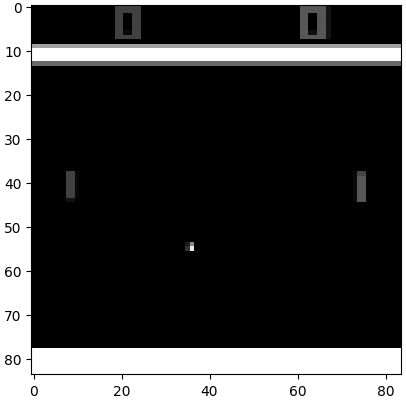</p>

### The Action Space

As described in the [Pong](https://pettingzoo.farama.org/environments/atari/pong/) page, action is `Discrete(6)`, so:
- Action shape is _(1,)_
- Action values are in range [0,5]

## Environment Setup and Preprocessing

In [2]:
import numpy as np
import gymnasium as gym
import ale_py
from datetime import datetime
import os
import sys
import yaml
import wandb
from wandb.integration.sb3 import WandbCallback

import supersuit as ss
from pettingzoo.atari import pong_v3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy

2025-12-13 14:39:17.020815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765636757.413850      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765636757.548986      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace package

In [3]:
class PongWrapper(gym.Wrapper):
    """
    Wrapper for the environment using the supersuit library.
    """
    def __init__(self, env, frame_stack=4):
        env = ss.color_reduction_v0(env, mode="B")
        env = ss.resize_v1(env, x_size=84, y_size=84)
        env = ss.frame_stack_v1(env, frame_stack, stack_dim=0)
        env = ss.dtype_v0(env, dtype=np.float32)
        env = ss.normalize_obs_v0(env, env_min=0, env_max=1)
        env = ss.reshape_v0(env, (frame_stack, 84, 84))
        
        super().__init__(env)

In [4]:
# Create training environment for single-agent Pong
def create_single_agent_env(n_envs=4, frame_stack=4):
    """Create vectorized environment for single-agent training"""
    env = make_vec_env(
        "ALE/Pong-v5",
        n_envs=n_envs,
        wrapper_class=PongWrapper,
        wrapper_kwargs={"frame_stack": frame_stack},
        env_kwargs={"frameskip": 4}
    )
    return env

# Test environment
train_env = create_single_agent_env(n_envs=4)
print("Observation space:", train_env.observation_space)
print("Action space:", train_env.action_space)
print("Number of actions:", train_env.action_space.n)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


Observation space: Box(0.0, 1.0, (4, 84, 84), float32)
Action space: Discrete(6)
Number of actions: 6


**We choose PPO (Proximal Policy Optimization) because:**
- It is the most stable on Atari games.
- It works well with high-dimensional visual inputs.
- It is widely used in the literature for Pong.
- SB3 provides a strong implementation with CNN policies.

## Hyperparameters

In [12]:
# Define parameter grid for tuning
param_grid = [
    {
        "learning_rate": 2.5e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "gamma": 0.99,
        "clip_range": 0.2,
    },
    {
        "learning_rate": 1e-3,
        "n_steps": 1024,
        "batch_size": 128,
        "gamma": 0.95,
        "clip_range": 0.1,
    },
    {
        "learning_rate": 5e-4,
        "n_steps": 1024,
        "batch_size": 256,
        "gamma": 0.99,
        "clip_range": 0.3,
    },
]

def tune_parameters(params, trial_name):
    """Train and evaluate with given parameters"""
    print(f"\nTrial: {trial_name}")
    print(f"Parameters: {params}")
    
    # Create environment
    env = create_single_agent_env(n_envs=2)
    
    # Create model - IMPORTANT: Add normalize_images=False for pre-normalized images
    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=params["learning_rate"],
        n_steps=params["n_steps"],
        batch_size=params["batch_size"],
        n_epochs=4,
        gamma=params["gamma"],
        clip_range=params["clip_range"],
        ent_coef=0.01,
        verbose=0,
        policy_kwargs={"normalize_images": False}  # ADD THIS LINE
    )
    
    # Train for shorter duration for tuning
    model.learn(total_timesteps=200000)
    
    # Evaluate
    eval_env = create_single_agent_env(n_envs=1)
    mean_reward, std_reward = evaluate_policy(
        model, 
        eval_env, 
        n_eval_episodes=10,
        deterministic=True
    )
    
    print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
    
    env.close()
    eval_env.close()
    
    return mean_reward, params

# Run hyperparameter tuning
results = []
for i, params in enumerate(param_grid):
    reward, best_params = tune_parameters(params, f"Trial_{i+1}")
    results.append((reward, best_params))

# Select best parameters
best_reward, best_params = max(results, key=lambda x: x[0])
print(f"\nBest parameters: {best_params}")
print(f"Best reward: {best_reward:.2f}")


Trial: Trial_1
Parameters: {'learning_rate': 0.00025, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.99, 'clip_range': 0.2}
Mean reward: -10.20 ± 3.43

Trial: Trial_2
Parameters: {'learning_rate': 0.001, 'n_steps': 1024, 'batch_size': 128, 'gamma': 0.95, 'clip_range': 0.1}
Mean reward: -15.40 ± 2.46

Trial: Trial_3
Parameters: {'learning_rate': 0.0005, 'n_steps': 1024, 'batch_size': 256, 'gamma': 0.99, 'clip_range': 0.3}
Mean reward: -17.40 ± 2.58

Best parameters: {'learning_rate': 0.00025, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.99, 'clip_range': 0.2}
Best reward: -10.20


In [6]:
best_params = {
        "learning_rate": 2.5e-4,
        "n_steps": 2048,
        "batch_size": 64,
        "gamma": 0.99,
        "clip_range": 0.2,
    }

In [7]:
# Initialize wandb
wandb.init(
    project="pml-pong-tournament",
    config=best_params,
    name="ppo-pong-final",
    sync_tensorboard=False,
    save_code=False,
    mode="disabled"
)

# Create final training environment
final_env = create_single_agent_env(n_envs=8)

# Create PPO model with best parameters - ADD normalize_images=False
model = PPO(
    "CnnPolicy",
    final_env,
    learning_rate=best_params["learning_rate"],
    n_steps=best_params["n_steps"],
    batch_size=best_params["batch_size"],
    n_epochs=4,
    gamma=best_params["gamma"],
    clip_range=best_params["clip_range"],
    ent_coef=0.01,
    verbose=1,
    tensorboard_log="runs/ppo_pong",
    policy_kwargs={"normalize_images": False}  # ADD THIS
)

# Create evaluation callback
eval_env = create_single_agent_env(n_envs=1)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./models/best/",
    log_path="./logs/",
    eval_freq=10000,
    deterministic=True,
)

# Train
print("Starting final training...")
model.learn(
    total_timesteps=1500000,
    callback=[eval_callback],
    progress_bar=True,
    tb_log_name="ppo_final"
)

# Final evaluation
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=20,
    deterministic=True
)

print(f"\nFinal single-player performance:")
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Win rate: {(mean_reward + 21) / 42 * 100:.1f}%")

wandb.finish()

/usr/local/lib/python3.11/dist-packages/notebook/notebookapp.py:188: DeprecationWarning: invalid escape sequence '\/'
  print("""
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
/usr/local/lib/python3.11/dist-packages/google/colab/_import_hooks/_pydrive.py:21: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp  # pylint: disable=deprecated-module
/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py:202: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/m

Using cuda device
Starting final training...
Logging to runs/ppo_pong/ppo_final_1


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 924      |
|    ep_rew_mean     | -20.3    |
| time/              |          |
|    fps             | 655      |
|    iterations      | 1        |
|    time_elapsed    | 24       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 930         |
|    ep_rew_mean          | -20.2       |
| time/                   |             |
|    fps                  | 574         |
|    iterations           | 2           |
|    time_elapsed         | 57          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.005244785 |
|    clip_fraction        | 0.0112      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.00403     |
|    learning_rate        | 0.

Eval num_timesteps=80000, episode_reward=-17.80 +/- 2.14

Episode length: 1617.80 +/- 319.18

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.62e+03    |
|    mean_reward          | -17.8       |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.008790458 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00333    |
|    n_updates            | 16          |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 0.0682      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 986      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 483      |
|    iterations      | 5        |
|    time_elapsed    | 169      |
|    total_timesteps | 81920    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -19.9       |
| time/                   |             |
|    fps                  | 488         |
|    iterations           | 6           |
|    time_elapsed         | 201         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.009906276 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.526       |
|    learning_rate        | 0.

Eval num_timesteps=160000, episode_reward=-15.80 +/- 2.71

Episode length: 2169.20 +/- 238.63

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2.17e+03    |
|    mean_reward          | -15.8       |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.013568306 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0158     |
|    n_updates            | 36          |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 0.0745      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.24e+03 |
|    ep_rew_mean     | -19      |
| time/              |          |
|    fps             | 467      |
|    iterations      | 10       |
|    time_elapsed    | 350      |
|    total_timesteps | 163840   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.31e+03    |
|    ep_rew_mean          | -18.7       |
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 11          |
|    time_elapsed         | 381         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.015617988 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.

Eval num_timesteps=240000, episode_reward=-13.80 +/- 2.04

Episode length: 2697.80 +/- 291.31

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 2.7e+03    |
|    mean_reward          | -13.8      |
| time/                   |            |
|    total_timesteps      | 240000     |
| train/                  |            |
|    approx_kl            | 0.01904076 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.61      |
|    explained_variance   | 0.508      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0482    |
|    n_updates            | 56         |
|    policy_gradient_loss | -0.0309    |
|    value_loss           | 0.0621     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.6e+03  |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    fps             | 458      |
|    iterations      | 15       |
|    time_elapsed    | 535      |
|    total_timesteps | 245760   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.67e+03    |
|    ep_rew_mean          | -17.4       |
| time/                   |             |
|    fps                  | 462         |
|    iterations           | 16          |
|    time_elapsed         | 567         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.021809539 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.539       |
|    learning_rate        | 0.

Eval num_timesteps=320000, episode_reward=-13.60 +/- 1.36

Episode length: 3069.80 +/- 355.69

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.07e+03    |
|    mean_reward          | -13.6       |
| time/                   |             |
|    total_timesteps      | 320000      |
| train/                  |             |
|    approx_kl            | 0.024500465 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.458       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0377     |
|    n_updates            | 76          |
|    policy_gradient_loss | -0.0354     |
|    value_loss           | 0.057       |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.95e+03 |
|    ep_rew_mean     | -16.4    |
| time/              |          |
|    fps             | 451      |
|    iterations      | 20       |
|    time_elapsed    | 725      |
|    total_timesteps | 327680   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.99e+03    |
|    ep_rew_mean          | -16.3       |
| time/                   |             |
|    fps                  | 455         |
|    iterations           | 21          |
|    time_elapsed         | 756         |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.027236002 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.483       |
|    learning_rate        | 0.

Eval num_timesteps=400000, episode_reward=-7.20 +/- 2.48

Episode length: 3680.00 +/- 227.44

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.68e+03   |
|    mean_reward          | -7.2       |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.03025235 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.5       |
|    explained_variance   | 0.439      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0468    |
|    n_updates            | 96         |
|    policy_gradient_loss | -0.0408    |
|    value_loss           | 0.0597     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.24e+03 |
|    ep_rew_mean     | -15.3    |
| time/              |          |
|    fps             | 445      |
|    iterations      | 25       |
|    time_elapsed    | 919      |
|    total_timesteps | 409600   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.29e+03    |
|    ep_rew_mean          | -15         |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 26          |
|    time_elapsed         | 951         |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.033062547 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.

Eval num_timesteps=480000, episode_reward=-8.20 +/- 3.19

Episode length: 3782.00 +/- 766.56

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.78e+03    |
|    mean_reward          | -8.2        |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.038228832 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.436       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0881     |
|    n_updates            | 116         |
|    policy_gradient_loss | -0.0432     |
|    value_loss           | 0.0524      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.48e+03 |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    fps             | 440      |
|    iterations      | 30       |
|    t

Eval num_timesteps=560000, episode_reward=-8.80 +/- 2.32

Episode length: 4027.60 +/- 222.09

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 4.03e+03   |
|    mean_reward          | -8.8       |
| time/                   |            |
|    total_timesteps      | 560000     |
| train/                  |            |
|    approx_kl            | 0.04198306 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.514      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.056     |
|    n_updates            | 136        |
|    policy_gradient_loss | -0.0449    |
|    value_loss           | 0.0573     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.78e+03 |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    fps             | 435      |
|    iterations      | 35       |
|    time_elapsed    | 1

Eval num_timesteps=640000, episode_reward=-4.80 +/- 4.40

Episode length: 3582.40 +/- 249.12

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 3.58e+03  |
|    mean_reward          | -4.8      |
| time/                   |           |
|    total_timesteps      | 640000    |
| train/                  |           |
|    approx_kl            | 0.0466209 |
|    clip_fraction        | 0.343     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.36     |
|    explained_variance   | 0.522     |
|    learning_rate        | 0.00025   |
|    loss                 | -0.0578   |
|    n_updates            | 156       |
|    policy_gradient_loss | -0.0476   |
|    value_loss           | 0.0541    |
---------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.98e+03 |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    fps             | 433      |
|    iterations      | 40       |
|    time_elapsed    | 1510     |
|    total_timesteps | 655360   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.04e+03    |
|    ep_rew_mean          | -11.2       |
| time/                   |             |
|    fps                  | 435         |
|    iterations           | 41          |
|    time_elapsed         | 1541        |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.049638275 |
|    clip_fraction        | 0.341       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.

Eval num_timesteps=720000, episode_reward=0.60 +/- 3.93

Episode length: 3800.80 +/- 227.18

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.8e+03     |
|    mean_reward          | 0.6         |
| time/                   |             |
|    total_timesteps      | 720000      |
| train/                  |             |
|    approx_kl            | 0.051307425 |
|    clip_fraction        | 0.354       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0646     |
|    n_updates            | 172         |
|    policy_gradient_loss | -0.0456     |
|    value_loss           | 0.0544      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.11e+03 |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    fps             | 429      |
|    iterations      | 44       |
|    time_elapsed    | 1676     |
|    total_timesteps | 720896   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.13e+03    |
|    ep_rew_mean          | -10.1       |
| time/                   |             |
|    fps                  | 431         |
|    iterations           | 45          |
|    time_elapsed         | 1707        |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.050916016 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.

Eval num_timesteps=800000, episode_reward=-2.20 +/- 3.66

Episode length: 4000.00 +/- 469.11

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 4e+03      |
|    mean_reward          | -2.2       |
| time/                   |            |
|    total_timesteps      | 800000     |
| train/                  |            |
|    approx_kl            | 0.05970619 |
|    clip_fraction        | 0.354      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.24      |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0704    |
|    n_updates            | 192        |
|    policy_gradient_loss | -0.047     |
|    value_loss           | 0.0528     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.22e+03 |
|    ep_rew_mean     | -9.12    |
| time/              |          |
|    fps             | 427      |
|    iterations      | 49       |
|    time_elapsed    | 1

Eval num_timesteps=880000, episode_reward=-0.80 +/- 4.12

Episode length: 3404.00 +/- 157.98

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.4e+03     |
|    mean_reward          | -0.8        |
| time/                   |             |
|    total_timesteps      | 880000      |
| train/                  |             |
|    approx_kl            | 0.057882603 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0636     |
|    n_updates            | 212         |
|    policy_gradient_loss | -0.045      |
|    value_loss           | 0.0557      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.3e+03  |
|    ep_rew_mean     | -7.74    |
| time/              |          |
|    fps             | 427      |
|    iterations      | 54       |
|    t

Eval num_timesteps=960000, episode_reward=-0.40 +/- 4.18

Episode length: 3867.40 +/- 198.32

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.87e+03   |
|    mean_reward          | -0.4       |
| time/                   |            |
|    total_timesteps      | 960000     |
| train/                  |            |
|    approx_kl            | 0.06566869 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.622      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0285    |
|    n_updates            | 232        |
|    policy_gradient_loss | -0.0447    |
|    value_loss           | 0.0582     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.31e+03 |
|    ep_rew_mean     | -6.88    |
| time/              |          |
|    fps             | 424      |
|    iterations      | 59       |
|    time_elapsed    | 2

Eval num_timesteps=1040000, episode_reward=2.40 +/- 4.22

Episode length: 4286.40 +/- 306.82

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 4.29e+03   |
|    mean_reward          | 2.4        |
| time/                   |            |
|    total_timesteps      | 1040000    |
| train/                  |            |
|    approx_kl            | 0.06774712 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.632      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0424    |
|    n_updates            | 252        |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 0.0551     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.36e+03 |
|    ep_rew_mean     | -6.17    |
| time/              |          |
|    fps             | 423      |
|    iterations      | 64       |
|    time_elapsed    | 2477     |
|    total_timesteps | 1048576  |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.4e+03    |
|    ep_rew_mean          | -5.84      |
| time/                   |            |
|    fps                  | 424        |
|    iterations           | 65         |
|    time_elapsed         | 2508       |
|    total_timesteps      | 1064960    |
| train/                  |            |
|    approx_kl            | 0.07189326 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.634      |
|    learning_rate        | 0.00025    |
|   

Eval num_timesteps=1120000, episode_reward=7.20 +/- 1.47

Episode length: 3753.80 +/- 219.42

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.75e+03   |
|    mean_reward          | 7.2        |
| time/                   |            |
|    total_timesteps      | 1120000    |
| train/                  |            |
|    approx_kl            | 0.07743374 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.639      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.107     |
|    n_updates            | 272        |
|    policy_gradient_loss | -0.0479    |
|    value_loss           | 0.0549     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.47e+03 |
|    ep_rew_mean     | -4.89    |
| time/              |          |
|    fps             | 422      |
|    iterations      | 69       |
|    time_elapsed    | 2675     |
|    total_timesteps | 1130496  |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3.5e+03   |
|    ep_rew_mean          | -4.73     |
| time/                   |           |
|    fps                  | 423       |
|    iterations           | 70        |
|    time_elapsed         | 2707      |
|    total_timesteps      | 1146880   |
| train/                  |           |
|    approx_kl            | 0.0762427 |
|    clip_fraction        | 0.368     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.12     |
|    explained_variance   | 0.607     |
|    learning_rate        | 0.00025   |
|    loss           

Eval num_timesteps=1200000, episode_reward=4.80 +/- 5.15

Episode length: 3629.40 +/- 460.29

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.63e+03   |
|    mean_reward          | 4.8        |
| time/                   |            |
|    total_timesteps      | 1200000    |
| train/                  |            |
|    approx_kl            | 0.07763674 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.625      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0402    |
|    n_updates            | 292        |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.0548     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.56e+03 |
|    ep_rew_mean     | -3.82    |
| time/              |          |
|    fps             | 421      |
|    iterations      | 74       |
|    time_elapsed    | 2

Eval num_timesteps=1280000, episode_reward=0.20 +/- 4.71

Episode length: 3963.80 +/- 389.55

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.96e+03    |
|    mean_reward          | 0.2         |
| time/                   |             |
|    total_timesteps      | 1280000     |
| train/                  |             |
|    approx_kl            | 0.088987075 |
|    clip_fraction        | 0.381       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.107      |
|    n_updates            | 312         |
|    policy_gradient_loss | -0.0496     |
|    value_loss           | 0.0577      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.58e+03 |
|    ep_rew_mean     | -3.55    |
| time/              |          |
|    fps             | 420      |
|    iterations      | 79       |
|    t

Eval num_timesteps=1360000, episode_reward=6.20 +/- 2.99

Episode length: 3711.20 +/- 349.13

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.71e+03   |
|    mean_reward          | 6.2        |
| time/                   |            |
|    total_timesteps      | 1360000    |
| train/                  |            |
|    approx_kl            | 0.08504768 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.06      |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.106     |
|    n_updates            | 332        |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 0.0549     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.61e+03 |
|    ep_rew_mean     | -2.68    |
| time/              |          |
|    fps             | 420      |
|    iterations      | 84       |
|    time_elapsed    | 3

Eval num_timesteps=1440000, episode_reward=3.00 +/- 3.03

Episode length: 3836.20 +/- 284.52

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 3.84e+03  |
|    mean_reward          | 3         |
| time/                   |           |
|    total_timesteps      | 1440000   |
| train/                  |           |
|    approx_kl            | 0.0899919 |
|    clip_fraction        | 0.389     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.09     |
|    explained_variance   | 0.613     |
|    learning_rate        | 0.00025   |
|    loss                 | -0.0694   |
|    n_updates            | 348       |
|    policy_gradient_loss | -0.0506   |
|    value_loss           | 0.0557    |
---------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.62e+03 |
|    ep_rew_mean     | -2.2     |
| time/              |          |
|    fps             | 419      |
|    iterations      | 88       |
|    time_elapsed    | 3439     |
|    tot


Final single-player performance:
Mean reward: 7.60 ± 3.80
Win rate: 68.1%


In [11]:
import numpy as np
import supersuit as ss
from pettingzoo.atari import pong_v3
from stable_baselines3 import PPO
import imageio
import warnings
import os
import random
import logging
import sys
import importlib

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
# IMPORTANT: Update your group name here (e.g., 'G01', 'G02', etc.)
GROUP_NAME = "G03" 
# Update this path to where your model is saved relative to the notebook/script
MODEL_PATH = "models/best/best_model.zip" 
# ---

# Helper function to create the environment (copied from your utils.py/wrappers.py)
def make_env(render_mode="rgb_array"):
    """Creates the pre-processed Pong environment."""
    env = pong_v3.env(num_players=2, render_mode=render_mode)
    # Apply the same SuperSuit wrappers as used in training/tournament setup
    env = ss.sticky_actions_v0(env, repeat_action_probability=0.25)
    env = ss.color_reduction_v0(env, mode="B")
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4, stack_dim=0)
    env = ss.dtype_v0(env, dtype=np.float32)
    env = ss.normalize_obs_v0(env, env_min=0, env_max=1)
    env = ss.reshape_v0(env, (4, 84, 84))
    
    # Resetting the environment with seed as done in the professor's setup
    MAX_INT = int(10e6)
    seed = random.randint(0, MAX_INT)
    env.reset(seed=seed)
    env.action_space(env.possible_agents[0]).seed(seed)
    
    return env

# 1. Load Your Model
print(f"Attempting to load PPO model from: {MODEL_PATH}")
try:
    trained_model = PPO.load(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load model. Check path and file integrity. Error: {e}")
    # Exit or use a dummy model if critical
    # sys.exit(1)

Attempting to load PPO model from: models/best/best_model.zip
Model loaded successfully.


In [13]:
class RandomAgent:
    """
    A simple agent that chooses a random action.
    It takes an observation but ignores it, matching the expected 
    interface for tournament agents (which often come from SB3/RLlib).
    """
    def __init__(self, action_space):
        self.action_space = action_space

    def predict(self, observation, deterministic=True):
        """
        Returns a random action. The 'deterministic' argument is ignored.
        Returns: (action, None) to match SB3's .predict() signature.
        """
        # .sample() gets a random action from the discrete action space
        action = self.action_space.sample()
        return action, None

    # Dummy methods for compatibility with tournament runner if needed
    def learn(self, *args, **kwargs):
        pass

    def save(self, *args, **kwargs):
        pass

In [14]:
def evaluate_agent(ppo_model, opponent_agent, n_episodes=20, video_path='pong_ppo_vs_random.mp4'):
    """
    Evaluates the PPO model against a specified opponent agent.
    PPO model plays first_0 (Right), Opponent plays second_0 (Left).
    """
    env = make_env(render_mode="rgb_array")
    
    total_rewards = {'first_0': 0, 'second_0': 0}
    wins = {'first_0': 0, 'second_0': 0}
    video_frames = []
    
    print("\n--- Starting PPO Agent vs Random Agent Evaluation ---")
    print(f"PPO Agent: Right Paddle ('first_0') | Opponent: Left Paddle ('second_0')")

    for episode in range(n_episodes):
        env.reset()
        episode_rewards = {'first_0': 0, 'second_0': 0}
        
        # PettingZoo Agent Iteration Loop
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            
            episode_rewards[agent] += reward
            
            if termination or truncation:
                action = None
            else:
                if agent == 'first_0':
                    # RIGHT PLAYER (Trained PPO Model)
                    action, _ = ppo_model.predict(observation, deterministic=True)
                elif agent == 'second_0':
                    # LEFT PLAYER (Random Opponent)
                    action, _ = opponent_agent.predict(observation, deterministic=True)
                else:
                    action = env.action_space(agent).sample() # Fallback random action
            
            env.step(action)
            
            # Capture frames for video (first episode only)
            if episode == 0 and len(video_frames) < 1500: # Limit frames
                frame = env.render()
                if frame is not None:
                    video_frames.append(frame)

        # Tally results
        right_score = episode_rewards['first_0']
        left_score = episode_rewards['second_0']
        
        total_rewards['first_0'] += right_score
        total_rewards['second_0'] += left_score
        
        if right_score > left_score:
            wins['first_0'] += 1
        elif left_score > right_score:
            wins['second_0'] += 1

        print(f"Episode {episode + 1:02d}: PPO (Right)={right_score:.1f}, Random (Left)={left_score:.1f}")

    env.close()

    # Report Results
    print("\n" + "="*40)
    print("PPO Agent vs Random Agent RESULTS")
    print("="*40)
    print(f"Total PPO Agent (Right) wins: {wins['first_0']} / {n_episodes}")
    print(f"Total Random Agent (Left) wins: {wins['second_0']} / {n_episodes}")
    print(f"PPO Agent Win Rate: {(wins['first_0']/n_episodes * 100):.1f}%")
    print(f"Avg PPO Agent Reward: {total_rewards['first_0']/n_episodes:.2f}")
    print("="*40)

    # Save Video
    if video_frames:
        imageio.mimsave(video_path, video_frames, fps=30)
        print(f"Video saved as '{video_path}'")
    else:
        print("No frames captured for video.")
        
    return total_rewards

# --- EXECUTE EVALUATION ---
# Create an instance of the random opponent
random_opponent = RandomAgent(env.action_space(env.possible_agents[0]))
# Run the evaluation
if 'trained_model' in locals():
    # Evaluate PPO model vs Random Agent over 20 episodes
    evaluate_agent(trained_model, random_opponent, n_episodes=20)


--- Starting PPO Agent vs Random Agent Evaluation ---
PPO Agent: Right Paddle ('first_0') | Opponent: Left Paddle ('second_0')
Episode 01: PPO (Right)=19.0, Random (Left)=-21.0
Episode 02: PPO (Right)=12.0, Random (Left)=-14.0
Episode 03: PPO (Right)=14.0, Random (Left)=-15.0
Episode 04: PPO (Right)=2.0, Random (Left)=-6.0
Episode 05: PPO (Right)=13.0, Random (Left)=-15.0
Episode 06: PPO (Right)=17.0, Random (Left)=-18.0
Episode 07: PPO (Right)=14.0, Random (Left)=-16.0
Episode 08: PPO (Right)=19.0, Random (Left)=-21.0
Episode 09: PPO (Right)=7.0, Random (Left)=-11.0
Episode 10: PPO (Right)=10.0, Random (Left)=-13.0
Episode 11: PPO (Right)=-15.0, Random (Left)=-5.0
Episode 12: PPO (Right)=8.0, Random (Left)=-14.0
Episode 13: PPO (Right)=16.0, Random (Left)=-17.0
Episode 14: PPO (Right)=6.0, Random (Left)=-11.0
Episode 15: PPO (Right)=13.0, Random (Left)=-17.0
Episode 16: PPO (Right)=1.0, Random (Left)=-4.0
Episode 17: PPO (Right)=7.0, Random (Left)=-12.0
Episode 18: PPO (Right)=18.0, 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 20: PPO (Right)=9.0, Random (Left)=-12.0

PPO Agent vs Random Agent RESULTS
Total PPO Agent (Right) wins: 19 / 20
Total Random Agent (Left) wins: 1 / 20
PPO Agent Win Rate: 95.0%
Avg PPO Agent Reward: 10.50
Video saved as 'pong_ppo_vs_random.mp4'


### Testing the Agent

Your agent will be tested, against other agents, in an environment similar to the following one:

**Notes**:
- It is important to consider that the agent will have to play on **both sides of the board**. That is, the agent must be able to play on the **right side** (by default in Gymnasium or Gym), but also on the **left side**.
- You can provide a **single model** to play both sides or, alternatively, you can provide **two models**, one model for each side of the board.

In [14]:
import supersuit as ss
from pettingzoo.atari import pong_v3

env = PongWrapper(pong_v3.env())

# Load the agents
model1 = loaded_model
model2 = loaded_model

rewards = {agent: 0 for agent in env.possible_agents}

# We evaluate here using an AEC environments
env.reset(seed=1234)
env.action_space(env.possible_agents[0]).seed(123)

for agent in env.agent_iter():
    obs, reward, termination, truncation, info = env.last()

    for a in env.agents:
        rewards[a] += env.rewards[a]

    if termination or truncation:
        break
    else:
        if agent == env.possible_agents[0]:
            act = model1.predict(obs)
        else:
            act = model2.predict(obs)
    env.step(act)

print("Final rewards:", rewards)
env.close()

AssertionError: 